# Neutrino oscillations - part 2 (10 Points)

1. Assuming you have fitted the data using the  $\chi^2$  method (explain why it’s fine), create a normalized histogram of $\chi^2$ -values. Overlay it with a  $\chi^2$  -distribution for the appropriate degrees of freedom and compare mean and variances of the two distributions.

* we precily know the x values (cosdec =  np.linspace(0, 1, N) and log10_energy = np.linspace(1, 2, N))
* we can generate y values with a accuracy $\sigma$
* and we have a given function $P = 1 -\sin^2(2\theta)\sin^2(1.27\frac{\Delta m^2 L}{E})$
    with the two mixig parameters $\sin^2(2\theta)$ (sin2theta) and $\Delta m^2$ (dm2)
    
    $$\chi^2 = \sum_i\frac{(y_i - f(x_i))^2}{\sigma_i^2}$$

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
import scipy.optimize as so
from scipy.stats import poisson

In [61]:
#using the functions provided in the example notebook in the Github repository, which already includes reasonable default parameters
#I just added a **2 to the sin(), like in the formula above
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 #shouldn't it be sin2theta and np.sin()**2 ?

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)

    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            
            i=i+1
                   
    return events

# funktion to generate data of one experiment, with N energy bins and N cos(declination) bins
def generate_data(N, sin2theta=0.9, dm2=2.4e-3):
    cosdec =  np.linspace(0, 1, N) # N steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, N) # N steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy
# run the experiment 
    events=run_experiment(energy,cosdec, sin2theta, dm2)

# lets create a data set with the events per bin
# energy, cosdec, events
    data = [[], [], []]
    i = 0
    for e in energy:
        for c in cosdec:
            data[0].append(e)
            data[1].append(c)
            data[2].append(events[i])#"energy, cosdec, events:",e,c, events[i])
            i=i+1
    return data

def chi_squared(param):
    sin2theta, dm2 = param 
    df = generate_data(10)
    energy, cosdec, events = df[0], df[1], df[2]
    chi2 = []
    i = 0
    for i in range(len(energy)):
        mu = atmo_event_rate(energy[i], cosdec[i],sin2theta,dm2) # also f(x) = atmo_event_rate(energy, cosdec,sin2theta,dm2)
        chi2.append((events[i] - mu)**2/mu) #sigma = sqrt(mu)
    return np.sum(chi2)

In [71]:
#fitting data with chi2
sin2theta, dm2 = [0.9, 2.4e-3]
model = so.minimize(chi_squared, x0 = [sin2theta, dm2],  bounds=[(0,10), (-10,10)])
print(model)

      fun: 85.76854554865763
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.51676957e+09, 1.92508016e+09])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 2
     njev: 25
   status: 0
  success: True
        x: array([0.89999993, 0.00239926])


In [81]:
# creating a normalized histogram of chi2
N = 1000
chi2array = []
for i in range(N):
    sin2theta, dm2 = [0.9, 2.4e-3]
    model = so.minimize(chi_squared, x0 = [sin2theta, dm2],  bounds=[(0,10), (-10,10)])
    if model["success"] == True and model["fun"] >= 0:
        chi2array.append(model["fun"])

(array([0.0002864 , 0.        , 0.00171841, 0.00458242, 0.00744644,
        0.01288806, 0.0203345 , 0.02520333, 0.03637298, 0.03064495,
        0.02921295, 0.02520333, 0.0191889 , 0.01804329, 0.01288806,
        0.00773284, 0.00315042, 0.00458242, 0.0008592 , 0.0008592 ,
        0.0008592 , 0.0002864 , 0.0002864 , 0.0002864 , 0.0005728 ]),
 array([ 66.35667598,  70.15189629,  73.9471166 ,  77.74233692,
         81.53755723,  85.33277754,  89.12799786,  92.92321817,
         96.71843848, 100.5136588 , 104.30887911, 108.10409942,
        111.89931973, 115.69454005, 119.48976036, 123.28498067,
        127.08020099, 130.8754213 , 134.67064161, 138.46586193,
        142.26108224, 146.05630255, 149.85152287, 153.64674318,
        157.44196349, 161.23718381]),
 <BarContainer object of 25 artists>)

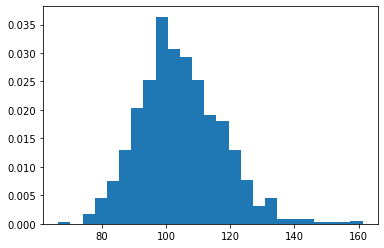

In [82]:
plt.hist(chi2array, density = True, bins = 25)

[97.68898890977351,
 95.5817079257237,
 99.6661642484829,
 104.5596065644864,
 85.06710385286576,
 97.8879722907075,
 101.64465954507186,
 99.12493556250061,
 99.8479581881629,
 104.48301679813842,
 92.92232787183487,
 147.20860722395764,
 101.20366518083888,
 104.49771338839345,
 92.48593497889641,
 99.96540304879548,
 90.85845481780116,
 117.4119256630611,
 104.09455987297505,
 92.02016651090682,
 110.34941438727213,
 119.67119119324688,
 101.79683495472085,
 122.7201127774914,
 110.68600675082921,
 111.77591381399037,
 112.34271757894518,
 100.63582282351977,
 98.53466152045957,
 88.33964921299027,
 86.54404554926779,
 125.38680088046083,
 117.20175883454081,
 108.24129989417915,
 104.9487681384287,
 100.05257731411714,
 97.8242810308705,
 114.64445461463669,
 102.82566785118215,
 93.11312289015864,
 105.8328038119288,
 112.28836834455564,
 110.33537340661145,
 132.28018997396617,
 117.28170953697304,
 114.19172641116506,
 93.31285014853765,
 95.00516714109628,
 -1264148793.7388227,

# COVID-19 self-testing and Bayesian theorem (5 Points)

#### Imaginary Test
* Given a COVID-19 infection, these tests only indicate a positive test result 60% of the time 
* a 1% chance that the test shows a positive result, despite no infection.
#### 1. Cast these numbers as Type I and Type II errors.
##### Type I error 
is the mistaken rejection of an actually true null hypothesis (also known as a "false positive")- The Probability to be tested positive although not having covid-19 - here $P(E+|-H) = 0.01$ is the probability of being falsly identified
##### Type II error 
is the failure to reject a null hypothesis that is actually false (also known as a "false negative") $P(E-|H) = 0.4$  The Probability to be tested negative although having covid-19 

#### 2. 2. Use Bayes’ theorem to compute the probability to be healthy, as a function of COVID- 19 prevalence in the general population, and display it in a graph ranging from 10−6 to 1). - I am guessing after a positive or a negative test

Lets start with the probabiliy of being healthy after a positive test result $P(-H|E+)$.

$-H$: Not Having Covid - Healthy

$H$:  Having Covid

$E-$: Negative Test Event

$E+$: Positive Test Event
#### Bayes’ theorem:

$$P(-H|E+) = \frac{P(E+|-H)P(-H)}{P(E+)} = \frac{P(E+|-H)P(-H)}{P(E+|H)P(H) + P(E+|-H)P(-H)} $$
with $P(H) = 1 -P(-H)$
$$= \frac{0.01 P(-H)}{0.6(1 - P(-H)) + 0.01 P(-H)}$$



In [2]:
def BayesHealthyPositiveTest(p):
    return 0.01*p/(0.6*(1-p)+0.01*p)

In [3]:
propHealthy = []
#log10_prevalence = np.linspace(-6, 0, 100)
prevalence = np.linspace(0, 1, 100)#10**log10_prevalence
for p in prevalence:
    propHealthy.append(BayesHealthyPositiveTest(p))
    

(1e-06, 1)

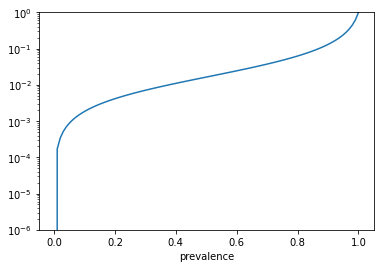

In [4]:
plt.plot(prevalence, propHealthy)
plt.xlabel("prevalence")
plt.yscale("log")
plt.ylim(10**(-6), 1)

Next the probabiliy of being healthy after a negative test result $P(-H|E-)$.

$-H$: Not Having Covid - Healthy

$H$:  Having Covid

$E-$: Negative Test Event

$E+$: Positive Test Event
#### Bayes’ theorem:

$$P(-H|E-) = \frac{P(E-|-H)P(-H)}{P(E-)} =     \frac{P(E-|-H)P(-H)}{P(E-|H)P(H) + P(E-|-H)P(-H)} $$
with $P(H) = 1 -P(-H)$
$$= \frac{0.99 P(-H)}{0.4(1 - P(-H)) + 0.99 P(-H)}$$



In [5]:
def BayesHealthyNegativeTest(p):
    return 0.99*p/(0.4*(1-p)+0.99*p)

(1e-06, 1)

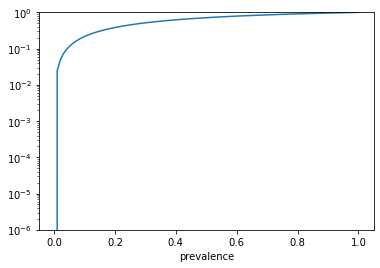

In [7]:
propHealthy = []
#log10_prevalence = np.linspace(-6, 0, 100)
prevalence = np.linspace(0, 1, 100)#10**log10_prevalence
for p in prevalence:
    propHealthy.append(BayesHealthyNegativeTest(p))
    
plt.plot(prevalence, propHealthy)
plt.xlabel("prevalence")
plt.yscale("log")
plt.ylim(10**(-6), 1)